#### This notebook is for interactively working with FluxNet and MiCASA data for viewing and preprocessing purposes.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
import hvplot.xarray
import hvplot.pandas
from bokeh.models import DatetimeTickFormatter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import glob
import os

ERROR 1: PROJ: proj_create_from_database: Open of /usr/local/other/GEOSpyD/24.4.0-0_py3.12/2024-05-31/share/proj failed


## Define Variables / Import MetaData

In [2]:
# Define misc variables
amer_filepath = 'ameriflux-data/'
mic_filepath = 'intermediates/'
timedelta = 'DD'

In [3]:
# Import site metadata csv
meta_file = amer_filepath + 'AmeriFlux-site-search-results-202410071335.tsv'
ameriflux_meta = pd.read_csv(meta_file, sep='\t')
fluxnet_meta = ameriflux_meta.loc[ameriflux_meta['AmeriFlux FLUXNET Data'] == 'Yes'] #use FLUXNET only

## Functions

In [4]:
# Define a single match file location function
def get_single_match(pattern):
    matches = glob.glob(pattern)
    if len(matches) == 1:
        return matches[0]
    elif len(matches) == 0:
        raise ValueError(f"No matches found")
    else:
        raise ValueError(f"Multiple matches found: {matches}")

In [5]:
def get_fluxnet_data(site_ID):
    # Import selected site daily subset data
    # site_lat = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
    # site_lon = fluxnet_meta.loc[fluxnet_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values
    sel_file = get_single_match(amer_filepath + 'AMF_' + site_ID + '_FLUXNET_SUBSET_*/AMF_' + site_ID + '_FLUXNET_SUBSET_' + timedelta + '_*.csv')
    fluxnet_sel = pd.read_csv(sel_file)

    # select subset of columns + convert to datetime objects    
    fluxnet_sel_sub = fluxnet_sel.loc[:,['TIMESTAMP','NEE_VUT_REF','NEE_VUT_REF_QC','GPP_NT_VUT_REF', 'GPP_DT_VUT_REF']].copy()
    fluxnet_sel_sub['TIMESTAMP'] = pd.to_datetime(fluxnet_sel_sub['TIMESTAMP'],format='%Y%m%d')
    fluxnet_sel_sub = fluxnet_sel_sub.set_index('TIMESTAMP')
    
    # Make a clean output df
    fluxnet_final = pd.DataFrame()
    
    # NEE
    ## Convert units
    ## FluxNet NEE_VUT_REF in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
    fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_sel_sub['NEE_VUT_REF']*1e-3/86400
    
    # GPP
    ## FluxNet GPP in DD (gC m-2 d-1) to MiCASA (kgC m-2 s-1)
    fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_DT_VUT_REF']*1e-3/86400
    fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_sel_sub['GPP_NT_VUT_REF']*1e-3/86400
    
    ## Mask bad QC values for NEE and GPP
    ## for daily FluxNet data, QC is fraction between 0-1, indicating percentage of measured and good quality gapfill data
    fluxnet_final['NEE (kgC m-2 s-1)'] = fluxnet_final['NEE (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
    fluxnet_final['GPP (DT) (kgC m-2 s-1)'] = fluxnet_final['GPP (DT) (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
    fluxnet_final['GPP (NT) (kgC m-2 s-1)'] = fluxnet_final['GPP (NT) (kgC m-2 s-1)'].mask(fluxnet_sel_sub['NEE_VUT_REF_QC'] < 1, np.nan)
    
    # Carry QC values into final 
    fluxnet_final['NEE_VUT_REF_QC'] = fluxnet_sel_sub['NEE_VUT_REF_QC'] 
    
    return fluxnet_final

In [6]:
def replace_outliers_with_nan(df, column):
    """Replaces outliers in a DataFrame column with NaN.

    Args:
        df (pd.DataFrame): The DataFrame.
        column (str): The column name to check for outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers replaced by NaN.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound), np.nan)
    return df

## Import FluxNet Data

In [7]:
# Define site ID
site_ID = 'CA-DBB'
fluxnet_final = get_fluxnet_data(site_ID)
fluxnet_final_clean = replace_outliers_with_nan(fluxnet_final,'GPP (DT) (kgC m-2 s-1)')

# Import MiCASA data

In [8]:
# Import simplified MiCASA from data-extract.py
micasa_ds = pd.DataFrame()
for variable in ['NEE', 'NPP']:
    filename = f'{site_ID}_micasa_{variable}_{timedelta}.csv'
    path = os.path.join(mic_filepath, filename)
    ds = pd.read_csv(path,index_col=0)
    ds.index = pd.to_datetime(ds.index)
    varname = variable + ' (kgC m-2 s-1)'
    micasa_ds[varname] = ds

## Append like datasets 

In [9]:
# NEE
NEE_ds = pd.DataFrame()
NEE_ds['MiCASA'] = micasa_ds['NEE (kgC m-2 s-1)']
NEE_ds['FluxNet'] = fluxnet_final['NEE (kgC m-2 s-1)']

In [10]:
# NPP
NPP_ds = pd.DataFrame()
NPP_ds['MiCASA'] = micasa_ds['NPP (kgC m-2 s-1)']
NPP_ds['FluxNet DT GPP/2'] = fluxnet_final['GPP (DT) (kgC m-2 s-1)']/2

## Display Site Info

In [11]:
# Define subset site info to display
site_subset = ['Site ID', 
                'Name', 
                'Vegetation Description (IGBP)', 
                'Climate Class Description (Koeppen)', 
                'Elevation (m)',
                'Years of AmeriFlux FLUXNET Data']

In [12]:
site_sel = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID][site_subset]
with pd.option_context('display.max_colwidth', None):
  display(site_sel)

,Site ID,Name,Vegetation Description (IGBP),Climate Class Description (Koeppen),Elevation (m),Years of AmeriFlux FLUXNET Data
38,CA-DBB,Delta Burns Bog,"Permanent Wetlands: Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh water","Mediterranean: mild with dry, warm summer",4.0,"2014, 2015, 2016, 2017, 2018, 2019, 2020"


## Create final static plots

Text(0.5, 0.9, 'CA-DBB')

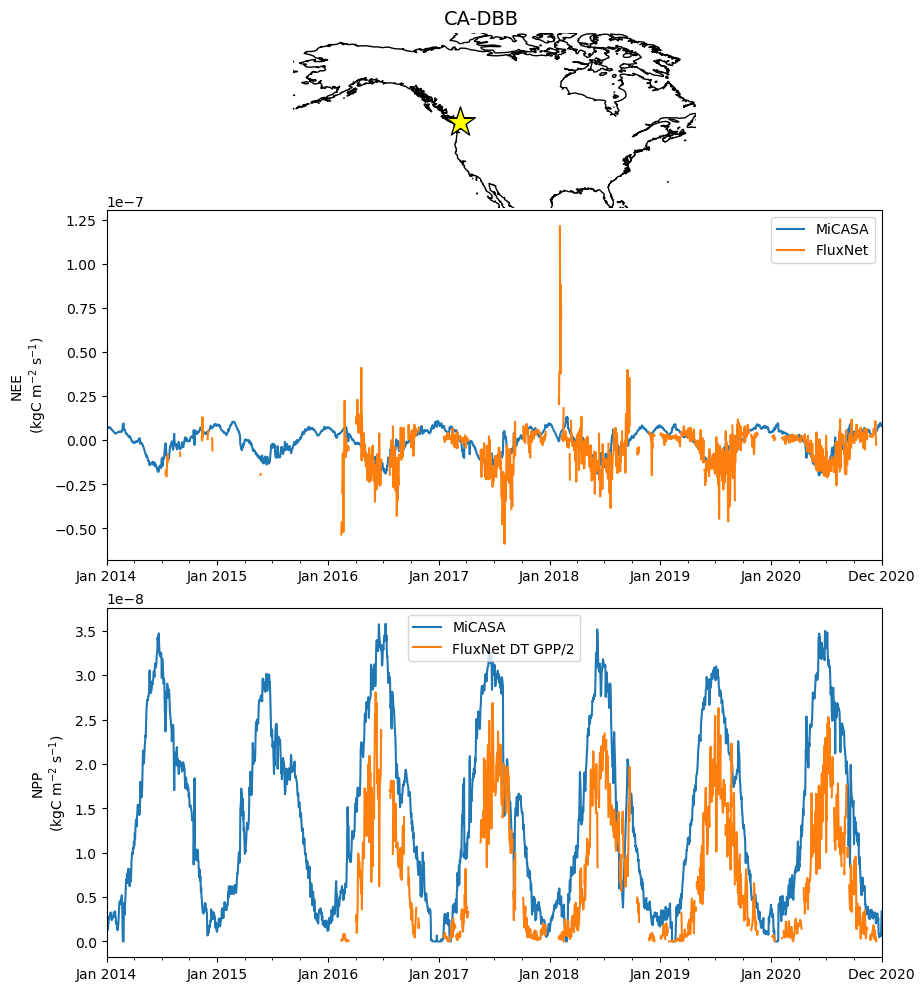

In [13]:
# Create a subplot grid with specific width ratios
fig, axs = plt.subplots(4, 1, 
                         gridspec_kw={'height_ratios': [1, 2,0.25,2],
                                      'hspace': 0.01},
                         figsize=(10, 12)) 

# Define the map projection
proj = ccrs.PlateCarree()

site_lat = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Latitude (degrees)'].values
site_lon = ameriflux_meta.loc[ameriflux_meta['Site ID'] == site_ID, 'Longitude (degrees)'].values

if site_lat >= 20:
    # North America extents
    min_lon, max_lon = -170, -57
    min_lat, max_lat = 25, 74

else:
    # South America extents
    min_lon, max_lon = -90, -30
    min_lat, max_lat = -60, 12
axs[0].axis('off')
axs[0] = plt.subplot(4, 1, 1, projection=proj,frameon=False)
axs[0].set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# axs[0].add_feature(cfeature.STATES)
# axs[0].add_feature(cfeature.BORDERS)
axs[0].coastlines()

axs[0].scatter(site_lon,site_lat,
       marker='*', 
       s=500,
       color='yellow',
       edgecolor='black',
               zorder=3)

NEE_ds.plot(ax=axs[1],ylabel = 'NEE\n(kgC m$^{-2}$ s$^{-1}$)')

axs[2].set_visible(False)

NPP_ds.plot(ax=axs[3],ylabel = 'NPP\n(kgC m$^{-2}$ s$^{-1}$)')

date_format = mdates.DateFormatter('%b %Y')
for i in range(1,4,2):
    axs[i].xaxis.set_major_formatter(date_format)
    axs[i].set_xlabel('') 
fig.suptitle(f'{site_ID}',y=0.9,fontsize=14)